### 라이브러리 불러오기

In [1]:
# library 불러오기
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict

## 데이터 살펴보기

* 데이터셋 출처: https://ailab.criteo.com/ressources/ (광고 리타겟팅 회사 Criteo)
        
    - **Timestamp**: 임프레션 타임스탬프
    - **UID**: 유저 고유 ID
    - **Campaign**: 고유 캠페인
    - **Conversion**: 임프레션 후 30일 이내에 전환이 있었으면 1, 그렇지 않으면 0
    - **Conversion ID**: 각 전환의 고유 식별자
    - **Click**: 임프레션 클릭한 경우 1, 그렇지 않으면 0
    - **Cost**: 광고에 사용된 비용
    - **Cat1-Cat9**: 광고와 관련된 범주형 특징

In [2]:
# 데이터 불러오기
df = pd.read_csv('./data/criteo_attribution_dataset_sampled_campaign_300_journey_over_2_points_balanced.csv')

# 데이터 살펴보기
df.head()
# jid컬럼은 uid + conversion_id를 합쳐
# 전환된 유저id를 좀 더 직관적으로 보기 위해

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,30763035,9312274,30867372,29196072,11409684,30763035,8549927,29196072,29520626,21670661_17559949
1,1,1398349,225512,32320979,28874676,0,-1,-1,0,1,...,30763035,9312274,1461750,29196072,26611394,1973606,30600973,9068204,15351053,32320979_-1
2,2,6206408,991626,29070160,27118781,1,1189040,23460283,1,1,...,30763035,9312274,23032073,29196072,11409686,1973606,9312274,14911188,21091111,29070160_23460283
3,3,12718518,2034017,2567135,10341182,1,2448781,2329559,0,1,...,25259032,7477605,28051086,23549932,32440044,28928366,11989417,29196072,32145478,2567135_2329559
4,4,4850218,748516,12566673,28137208,0,-1,-1,0,0,...,28928366,26597095,29562678,29196072,32440047,1973606,27807725,14911188,18291877,12566673_-1


In [5]:
# 자주 등장하는 상위 50개의 캠페인을 추출하여
# 분석을 진행
campaign_cnt = (
              df.groupby('campaign')['timestamp']
                .count()
                .sort_values(ascending=False)
                .reset_index()
                .rename(columns={'timestamp': 'camp_cnt'})
                .head(50)
              )

In [6]:
campaign_cnt

,campaign,camp_cnt
0,10341182,56151
1,30801593,39373
2,15398570,32891
3,15184511,31525
4,28351001,29132
5,29427842,15714
6,5061834,12954
7,18975823,12164
8,30491418,12142
9,6686701,9742


In [7]:
# 캠페인 상위 50개에 해당하는 이벤트만 가져온다.
df_part = df.merge(campaign_cnt, on = 'campaign')
print(df_part.campaign.nunique())
df = df_part

50


In [8]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451364 entries, 0 to 451363
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             451364 non-null  int64  
 1   Unnamed: 0.1           451364 non-null  int64  
 2   timestamp              451364 non-null  int64  
 3   uid                    451364 non-null  int64  
 4   campaign               451364 non-null  int64  
 5   conversion             451364 non-null  int64  
 6   conversion_timestamp   451364 non-null  int64  
 7   conversion_id          451364 non-null  int64  
 8   attribution            451364 non-null  int64  
 9   click                  451364 non-null  int64  
 10  click_pos              451364 non-null  int64  
 11  click_nb               451364 non-null  int64  
 12  cost                   451364 non-null  float64
 13  cpo                    451364 non-null  float64
 14  time_since_last_click  451364 non-nu

In [9]:
# 유저가 전환하기까지 얼마나 많은 캠페인에 노출되는지
# jid 별 이벤트 수 파악하기
event_count_per_jid = df.groupby('jid')['timestamp'].count().reset_index()
event_count_per_jid.head()

,jid,timestamp
0,10000148_-1,9
1,1000023_5282678,2
2,10000403_29178244,2
3,1000095_27795443,2
4,10001378_24057324,11


In [10]:
# 이벤트 수당 jid 파악하기 
jid_count_per_event_count = event_count_per_jid.groupby('timestamp')['jid'].count()
jid_count_per_event_count

timestamp
1       2653
2      36617
3      17702
4      10119
5       6548
       ...  
212        1
227        1
231        1
240        1
433        1
Name: jid, Length: 104, dtype: int64

In [11]:
# 위의 시리즈 형태의 결과를
# 데이터 프레임 형태로 변환
event_journey = pd.DataFrame({"event_count": jid_count_per_event_count.index, "journey_count":  jid_count_per_event_count.values})
event_journey.head(10)

,event_count,journey_count
0,1,2653
1,2,36617
2,3,17702
3,4,10119
4,5,6548
5,6,4597
6,7,3207
7,8,2489
8,9,1956
9,10,1516


In [12]:
# jid 1번당 5번의 캠페인을 본다
campaign_count_per_jid = df_part.groupby('jid')['campaign'].nunique().reset_index()
jid_count_per_event_count = campaign_count_per_jid.groupby('campaign')['jid'].count()
event_journey = pd.DataFrame({"campaign_count": jid_count_per_event_count.index, "journey_count":  jid_count_per_event_count.values})
event_journey.head(10)

,campaign_count,journey_count
0,1,89749
1,2,5120
2,3,472
3,4,44
4,5,3


## Logistic Regression 을 활용한 마케팅 예산 분배 최적화

* conversion 을 예측하는 모델을 만들고, 전환을 예측했을 때의 logistic regression 의 각 캠페인에 대한 학습된 가중치를 가져온다


In [13]:
# 데이터 전처리 하기
df_part.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,camp_cnt
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,9312274,30867372,29196072,11409684,30763035,8549927,29196072,29520626,21670661_17559949,7890
1,55,7851159,1238119,3661462,10474106,1,1672978,24286866,0,1,...,9312274,30867372,29196072,11409684,28928366,8549927,29196072,29520629,3661462_24286866,7890
2,76,9578475,1531823,8030609,10474106,1,1531964,16414421,0,1,...,9312274,7726221,29196072,11409684,32440041,8549927,29196072,9491351,8030609_16414421,7890
3,89,2626351,415988,25962703,10474106,1,1389157,8416473,0,1,...,9312274,30867372,29196072,11409684,1973606,8549927,14911188,9491354,25962703_8416473,7890
4,137,8769546,1373396,4813350,10474106,1,1710543,17834428,1,1,...,9312274,30867372,29196072,11409684,27093701,8549927,29196072,8661623,4813350_17834428,7890


In [14]:
# 먼저 timestamp 컬럼을 scaling 해준다
# minmazscaler를 통해 0-1사이의 값으로 만들어준다
min_max_scaler = MinMaxScaler()
df['timestamp_norm'] =  min_max_scaler.fit_transform(df[['timestamp']])

In [15]:
# 카테고리형 데이터를 모델이 이해할 수 있게
# 숫자형으로 바꾼다
# 캠페인, 카테고리 1~9
# on-hot encoding을 사용한다
# 2개의 카테고리 컬럼을 하나의 one_hot vector 컬럼으로 만든다.

# Step 1) 각 카테고리에 List 의 Index 를 하나씩 할당한다.
# Cat -> 1, Rabbit -> 2 ...
# 여기서는 카테고리 여러개를 합쳐서 한개의 카테고리 one-hot vector 를 만들려고 한다.
column_names = ['cat1', 'cat2']
mapper = {}  # List 의 인덱스를 저장할 mapper                                        
for column_idx, col_name in enumerate(column_names):  # 각 컬럼 별로 돌면서
    print(column_idx, col_name)   
    unique_values_per_column = df[col_name].unique() # Cat1 의 Unique 한 카테고리 종류를 먼저 가져온다.
    print(unique_values_per_column, len(unique_values_per_column))
    for val in unique_values_per_column: # cat1의 카테고리 아이디를 다 돌면서

        # val = 30763035 -> val * 10 = 307630350
        unique_category_id = val*10 + column_idx # 모든 카테고리에 중복되는 값이 없도록 아이디 * 10 + 1 을 한다.
        mapper[unique_category_id] = len(mapper)

0 cat1
[30763035 28928366 27093701 25259032  9312274  5824233  5642940   138937
  1973606] 9
1 cat2
[ 9312274 29196072  7477605 26597095  5642940 28928366  5824235 27093701
   138937  5824232 25259032  5824233  5824237 30763035 32440047  5824234
 26597096  5824236  1973606  3808271  5824239 32440053 32440040 32440041
 21611414  9068208 23998117] 27


In [16]:
# unique_category_id = val*10 + column_idx 이 코드를 더 설명해보면.
# 앞에서 cat1 의 column_idx는 0
# 맨끝자리는 카테고리 1을 의미하게 된다!
# 30763035 -> 307630350 -> 307630350 + 0
# column index (category index) = 0, category id = 30763035
mapper[30763035*10 + 0]

0

In [17]:
# One hot vector 만들기 
# Step 2) mapper 의 길이에 해당하는 빈 배열을 가져와서, 각 row에 해당하는 카테고리 값만 1로 채운다
def one_hot(values):
    v = np.zeros( len(mapper) ) # mapper 의 길이만큼 0으로 채운 배열을 준비한다
    for i, val in enumerate(values): # 각각의 값을 돌면서
        mapped_val_id = mapper[val*10 + i] # mapper 에서 우리가 저장한 index (id)를 가져온다
        v[mapped_val_id] = 1 # 그 index 만 1로 채운다
    return v 

In [18]:
# 각 row 마다 one hot vector 로 만들려고 하는 컬럼들의 list 를 불러온다
df_ext = df.copy()
df_ext['test_col'] = df_ext[column_names].values.tolist()
df_ext['test_col'].head()

# [30763035, 9312274]

0    [30763035, 9312274]
1    [30763035, 9312274]
2    [30763035, 9312274]
3    [28928366, 9312274]
4    [30763035, 9312274]
Name: test_col, dtype: object

In [19]:
df_ext['test_col'] = df_ext['test_col'].map(one_hot)
# [30763035, 9312274] 
list(df_ext['test_col'].head(1).values)

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])]

In [20]:
# 함수로 만들어준다
def map_one_hot(df, column_names, result_column_name):      
    mapper = {}                                             
    for i, col_name in enumerate(column_names):             
        for val in df[col_name].unique():                   
            mapper[val*10 + i] = len(mapper)
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            mapped_val_id = mapper[val*10 + i]
            v[mapped_val_id] = 1
        return v    
    
    df_ext = df.copy()
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext, mapper

In [21]:
# 카테고리를 원핫인코딩을 진행한다
df2, mapper_cate = map_one_hot(df, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

# 모델을 위한 데이터 프레임을 만든다
df3, mapper_campaigns = map_one_hot(df2, ['campaign'], 'campaigns')

In [22]:
df3.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat5,cat6,cat7,cat8,cat9,jid,camp_cnt,timestamp_norm,cats,campaigns
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,11409684,30763035,8549927,29196072,29520626,21670661_17559949,7890,0.078397,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,55,7851159,1238119,3661462,10474106,1,1672978,24286866,0,1,...,11409684,28928366,8549927,29196072,29520629,3661462_24286866,7890,0.463510,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,76,9578475,1531823,8030609,10474106,1,1531964,16414421,0,1,...,11409684,32440041,8549927,29196072,9491351,8030609_16414421,7890,0.573463,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,89,2626351,415988,25962703,10474106,1,1389157,8416473,0,1,...,11409684,1973606,8549927,14911188,9491354,25962703_8416473,7890,0.155731,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,137,8769546,1373396,4813350,10474106,1,1710543,17834428,1,1,...,11409684,27093701,8549927,29196072,8661623,4813350_17834428,7890,0.514153,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Logistic을 위해 추가 데이터 전처리

In [23]:
import numpy as np

In [ ]:
# jid 1 camp [0, 1, 0], cats [1, 0, 0], timestamp 1
# jid 1 camp [0, 0, 1], cats [0, 1, 0], timestamp 2

# =>
# jid 1개 당 feature vector 1개로 바꾸자

# jid 1 camp [0, 1, 1], cats [1, 1, 0] 


In [24]:
def pairwise_max(series):
    return np.max(series.tolist(), axis = 0).tolist()

In [26]:
# pairwise max 함수 뜯어보기
# 캠페인 여러개일 때 하나의 many-hot vector (여러개의 1이 있는 형태)로 변경해준다.
series = pd.Series([[0, 0, 0],[0, 1, 0]])
np.max(series.tolist(), axis = 0).tolist()

[0, 1, 0]

In [27]:
aggregation = {                      # aggregation specification for each feature
    'campaigns': pairwise_max, # one-hot
    'cats': pairwise_max, # # one-hot
    'click': 'sum', # click 의 sum
    'cost': 'sum', # 비용 sum
    'conversion': 'max' # jid 별로 전환했는지 안했는지 여부
}

In [28]:
# 우리가 원하는 feature 를 만들기 위해 각각의 column에 aggregation 을 수행한다
df_agg = df3.groupby(['jid']).agg(aggregation)

In [29]:
# features 컬럼에 전체 feature 를 묶어서 list 로 넣는다
df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
df_agg['features'].head()

jid
10000148_-1          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1000023_5282678      [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10000403_29178244    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1000095_27795443     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10001378_24057324    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: features, dtype: object

In [30]:
x = np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values)
y = df_agg['conversion'].values

In [31]:
x.shape
# jid 95388
# feature 의 길이 376

y.shape

# 각각의 95388개의 jid 별로 전환되었는지, 1 or 0 

(95388,)

* 참고: numpy stack and hstack

In [33]:
# Dataset Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)            # train-test split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20)  # train-validation split

In [34]:
# Logistic Regression 학습
# keras, tensorflow 를 사용한다
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
# 376 개의 feature 를 input 으로 받아 단 1개의 output 을 내보내는 layer 하나를 만든다!

# Step 1: 로지스틱 리그레션 모델 구조를 만든다
m = np.shape(x)[1] 
model = keras.Sequential()  
model.add(layers.Dense(1, input_dim = m, activation = 'sigmoid', name = 'contributions')) 

# Step 2: 손실함수와 optimizer 를 선택해주면 됩니다
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 


model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
477/477 [==============================] - 2s 2ms/step - loss: 0.5541 - accuracy: 0.7835 - val_loss: 0.5038 - val_accuracy: 0.7904
Epoch 2/10
477/477 [==============================] - 0s 1ms/step - loss: 0.4902 - accuracy: 0.7931 - val_loss: 0.4760 - val_accuracy: 0.7931
Epoch 3/10
477/477 [==============================] - 0s 1ms/step - loss: 0.4704 - accuracy: 0.7994 - val_loss: 0.4631 - val_accuracy: 0.7986
Epoch 4/10
477/477 [==============================] - 0s 955us/step - loss: 0.4591 - accuracy: 0.8031 - val_loss: 0.4553 - val_accuracy: 0.8027
Epoch 5/10
477/477 [==============================] - 0s 974us/step - loss: 0.4521 - accuracy: 0.8067 - val_loss: 0.4500 - val_accuracy: 0.8042
Epoch 6/10
477/477 [==============================] - 0s 929us/step - loss: 0.4470 - accuracy: 0.8093 - val_loss: 0.4466 - val_accuracy: 0.8047
Epoch 7/10
477/477 [==============================] - 0s 948us/step - loss: 0.4432 - accuracy: 0.8098 - val_loss: 0.4434 - val_accuracy: 0.806

In [36]:
# 각 캠페인의 기여도 계산 및 비교
n_campaigns = 50 # 50개
keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]

# 376 -> 50
len(keras_logreg)

50

In [37]:
from sklearn.utils.extmath import softmax

# softmax 함수를 사용해 합을 1.0 이 나오도록 함
keras_logreg = softmax([keras_logreg]).flatten()
keras_logreg

array([0.03927737, 0.00786877, 0.02462653, 0.01484167, 0.01494798,
       0.01539389, 0.02701676, 0.01906171, 0.01911393, 0.013288  ,
       0.02121651, 0.02544983, 0.02804163, 0.01677355, 0.01292758,
       0.01702556, 0.01635752, 0.02191192, 0.01967465, 0.01806852,
       0.01654442, 0.01499401, 0.02085404, 0.02306312, 0.02226652,
       0.01870164, 0.01619729, 0.01846212, 0.01378284, 0.01512428,
       0.01516847, 0.02137531, 0.01879762, 0.0261014 , 0.01547128,
       0.02625224, 0.02687813, 0.0380884 , 0.01659672, 0.0315389 ,
       0.02280912, 0.01478815, 0.02409881, 0.01097788, 0.01871542,
       0.0122455 , 0.01908492, 0.02870543, 0.01864826, 0.02078391],
      dtype=float32)

### Baseline: Last Click Attribution Model

In [38]:
df3['campaigns'].head()

0    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: campaigns, dtype: object

In [39]:
# 1) 각 캠페인마다 노출수를 세는 함수
def count_by_campaign(df):                         
    counters = np.zeros(n_campaigns) # 50 size 의 zero vector (array)
    for campaign_one_hot in df['campaigns'].values:
        campaign_id = np.argmax(campaign_one_hot)
        counters[campaign_id] = counters[campaign_id] + 1
    return counters

campaign_impressions = count_by_campaign(df3) 

In [40]:
campaign_impressions

array([ 7890.,  3917.,  9387., 56151.,  2860., 39373., 29132.,  4190.,
       15714.,  5337., 31525.,  8317.,  5440.,  5931.,  6434.,  3482.,
        8113.,  5199.,  3124., 32891.,  3604.,  9364.,  3301.,  7504.,
        9742., 12954.,  4396.,  2897.,  2760.,  4397.,  8565.,  5682.,
        4946., 12164.,  3645.,  6717., 12142.,  7752.,  3014.,  2647.,
        4329.,  3108.,  2857.,  2572.,  7374.,  3427.,  2705.,  3332.,
        6211.,  2849.])

In [41]:
# 2) Conversion 전에 마지막으로 본 캠페인의 수를 센다.

# 전환된 데이터셋
dfc = df3[df3['conversion'] == 1]

# 전환된 데이터셋 dfc 에서
# timestamp 가 max 인 데이터만 필터링 걸겠다
idx = dfc.groupby(['jid'])['timestamp_norm'].transform(max) == dfc['timestamp_norm']

In [42]:
# 마지막 전환에 얼마나 영향을 미쳤는지
# 마지막 전환일 때 각 캠페인 별로 몇번 노출되었는지 확인
campaign_conversions = count_by_campaign(dfc[idx])

In [43]:
# 캠페인 별 전환수를 캠페인 별 노출수로 나눠준다.
lta = campaign_conversions / campaign_impressions

In [44]:
# Logistic Regression 과 마찬가지로 기여도 Weight 의 합이 1이 되도록 조정한다.
lta_sum = lta.sum()
lta_normalize  = lta / lta_sum
print(sum(lta_normalize))

1.0000000000000002


In [45]:
import seaborn as sns

data1 = pd.DataFrame({"attribution":keras_logreg, "method": "logistic", "campaign": range(0, 50)})
data2 = pd.DataFrame({"attribution":lta_normalize, "method": "last", "campaign": range(0, 50)})
total = pd.concat([data1, data2]).reset_index()
total.head()

,index,attribution,method,campaign
0,0,0.039277,logistic,0
1,1,0.007869,logistic,1
2,2,0.024627,logistic,2
3,3,0.014842,logistic,3
4,4,0.014948,logistic,4


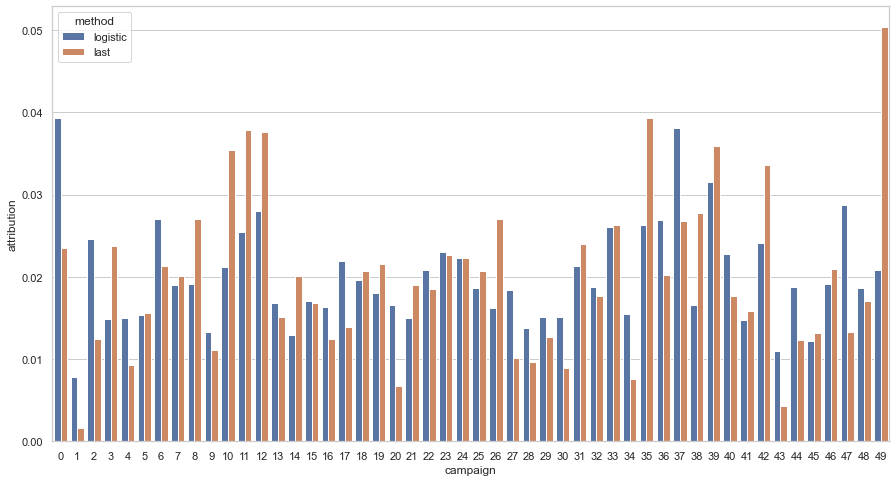

In [46]:
# 시각화
sns.set_theme(style="whitegrid")
g = sns.barplot(x= total.campaign,y = total.attribution, hue = total.method)
g.figure.set_size_inches(15, 8)

## 마케팅 예산 분배 시뮬레이션

* 예산을 지정한다.
* 예산을 캠페인의 기여도에 맞게 분배한다.
* 과거 유저의 전환 내역을 Replay 한다.
    * 캠페인이 노출되었다면 각 캠페인의 예산을 차감하고
    * 전환이 실제 되었다면 전환에 + 1을 해준다
    * 캠페인이 과거에 노출되었는데, 해당 캠페인에 대한 예산은 다 쓴 상태라면 blacklist 에 넣어준다.
* 계산은 conversion - blacklist 로 한다.

In [47]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution):
    # Weight 만큼 예산을 각 캠페인에 나눈다.
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    # 예산을 다 써서 시뮬레이션을 더 이상 진행할 수 없는 Journey  
    blacklist = set()

    # Conversion 이 일어난 Journey  
    conversions = set()

    # 데이터셋을 돌면서 시뮬레이션 시작
    for i in range(df.shape[0]):   
        # 해당 이벤트에서 노출된 캠페인 ID 를 가져오고                               
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        # 해당 jid를 가져온다.
        jid = df.loc[i]['jid']


        if jid not in blacklist:

            # 캠페인에 대한 예산이 있다면
            if budgets[campaign_id] >= 1:

                # 예산에서 1원를 사용하고
                budgets[campaign_id] = budgets[campaign_id] - 1

                # 전환했다면
                if(df.loc[i]['conversion'] == 1):
                    # 전환한 jid 로 추가한다.
                    conversions.add(jid)
            else:
                # 해당 캠페인에 대한 예산이 없다면, 
                # 과거에 해당 jid 에 대한 시뮬레이션은 멈춘다. 
                blacklist.add(jid)
            
    return len(conversions.difference(blacklist))

In [48]:
# 데이터가 너무 크면 시뮬레이션이 오래걸리니 강의에서는 1만개로 제약을 둔다.
# 강의에서는 같은 결과를 위해 랜덤 seed 를 고정해서 진행한다.
sample_data = df3.sample(n = 10000, random_state=6666)
sample_data = sample_data.sort_values('timestamp_norm')


* pitch (attributions ** pitch) : 각 캠페인 별 기여도의 격차를 크게 벌릴지 작게 벌릴지! 기여도를 제곱한다.

In [49]:
pitches = np.arange(0.0, 3.0, 0.5)
pitches
# 0, 0.5, 1, 1.5 ...

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

In [50]:
# lta
budget_total = 5000
attribution = lta

budget_lta = []
for pitch in pitches:
  conversion = simulate_budget_roi(sample_data.reset_index(), budget_total, attribution**pitch)
  print(pitch, conversion)
  budget_lta.append(conversion)

0.0 1763
0.5 1904
1.0 1906
1.5 1818
2.0 1711
2.5 1581


In [51]:
budget_total = 5000
attribution = keras_logreg

budget_logreg = []
for pitch in pitches:
  conversion = simulate_budget_roi(sample_data.reset_index(), budget_total, attribution**pitch)
  print(pitch, conversion)
  budget_logreg.append(conversion)

0.0 1763
0.5 1880
1.0 1965
1.5 1939
2.0 1894
2.5 1821


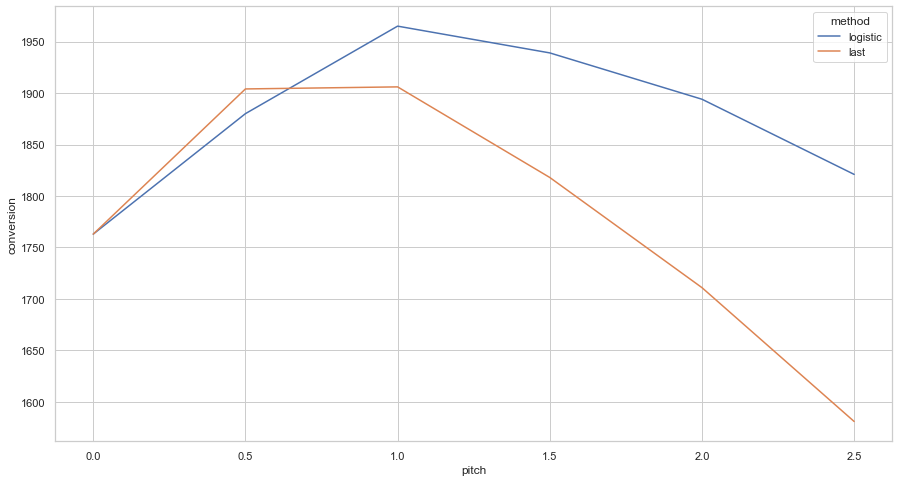

In [52]:
import seaborn as sns

data1 = pd.DataFrame({"conversion":budget_logreg, "method": "logistic", "pitch": pitches})
data2 = pd.DataFrame({"conversion":budget_lta, "method": "last", "pitch": pitches})
total = pd.concat([data1, data2]).reset_index()

sns.set_theme(style="whitegrid")
g = sns.lineplot(x= total.pitch ,y = total.conversion, hue = total.method)
g.figure.set_size_inches(15, 8)